In [ ]:
!pip install datasets

In [1]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=298e694fe7d90ac14aee2ee3ac2d542393a965ff4230b7da42e387a76db17b2b
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=dc21f9cf1ac65ef63c228d66fb78039af5c2048d767c5a4d89993724b84cc46a
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import multiprocessing
import seaborn as sns
import umap

from time import time 
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.cluster import KMeans
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, completeness_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils.extmath import randomized_svd
#from datasets import load_dataset
from gensim.models import LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel


In [69]:
sns.set_palette("colorblind", n_colors = 100)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !gdown --id 1N0U-i4PxT_DmTru0r7T5po-9f9cwGgB8 -O RedditComments2.csv
# !gdown --id 1dlV7huXQfim8brL7LIBy-M2kFR63P2Oh -O Reddit_metadata2.csv
# !gdown --id 1vT1g4Crj6s6z2YNjSyPx5Fvz5KTpBYSB -O annottated_reddit.csv

# KNN Baseline

Implementation of K-Nearest Neighbors clustering for sentiment analysis.
* We first prepare word feaures using bi-grams and Word2Vec embeddings and then use the features as input to the KNN. 
* We chose 3 clusters to represent the following classes: positive, neutral, negative.
* After clustering, we use Term Frequency - Inverse Document Frequency (tf-idf) and the distance of a word from the cluster center to determine the sentiment. 
* Ground truth psuedo labels are assigned to reviews based on the numeric star rating and used for evaluation. 



**Hyper Parameter Tuning**

Mainly focus on 
*   Word2Vec Parameters
*   KNN # of clusters, number of starting points, number of iterations 




Based on

1.   https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook
2.   https://github.com/rafaljanwojcik/Unsupervised-Sentiment-Analysis





# Reddit

## Initial Data Processing 

In [6]:
og_reddit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DNN project/lemmatized_reddit_og.csv') ## entire dataset
reddit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DNN project/lemmatized_reddit.csv') ## filtered dataset
reddit.drop('Unnamed: 0', axis = 1, inplace=True)
reddit.head()

,text,subreddit,bucket,annotation,lemmatized
0,"/r/france is pretty lively, with it's own ling...",europe,French politics,Non-Moral,france pretty lively lingo usually deliberatel...
1,The Le Pen brand of conservatism and classical...,europe,French politics,Non-Moral,le pen brand conservatism classical right wing...
2,"Clinton lead polls by 4%, well within a reason...",worldnews,French politics,Non-Moral,clinton lead poll reasonable margin lose le pe...
3,"Hey, fuck you. Us leftists will never support ...",worldnews,French politics,Equality,hey fuck leftist support le pen especially con...
4,You are simplifying it. Islam is not the sole ...,europe,French politics,Care,simplify islam not sole reason terrorism weste...


In [7]:
reddit.isna().sum()

text          0
subreddit     0
bucket        0
annotation    0
lemmatized    0
dtype: int64

In [8]:
## Using entire dataset for Word2Vec
tokenized = [row.split() for row in og_reddit['lemmatized'].astype(str)]
og_reddit['tokenized'] = tokenized
#print(sent[:3])

# looking for bigrams (based on kaggle notebook cited above)
phrases = Phrases(tokenized, min_count=5, progress_per=10000) 
bigram = Phraser(phrases)
sentences = bigram[tokenized]

In [9]:
reddit

,text,subreddit,bucket,annotation,lemmatized
0,"/r/france is pretty lively, with it's own ling...",europe,French politics,Non-Moral,france pretty lively lingo usually deliberatel...
1,The Le Pen brand of conservatism and classical...,europe,French politics,Non-Moral,le pen brand conservatism classical right wing...
2,"Clinton lead polls by 4%, well within a reason...",worldnews,French politics,Non-Moral,clinton lead poll reasonable margin lose le pe...
3,"Hey, fuck you. Us leftists will never support ...",worldnews,French politics,Equality,hey fuck leftist support le pen especially con...
4,You are simplifying it. Islam is not the sole ...,europe,French politics,Care,simplify islam not sole reason terrorism weste...
...,...,...,...,...,...
8698,Came here to say this. OP is sexist as hell be...,AmItheAsshole,Everyday Morality,Equality,come sexist hell pregnancy hormone thing way d...
8699,"At least you feel guilty, let’s you know you’r...",confession,Everyday Morality,Care,feel guilty let know human care guess
8700,Why are you dating this guy? Dude seems like a...,relationship_advice,Everyday Morality,Care,date guy dude like giant asshole not respect n...
8701,"Yeeeaah, if you take him back he's still gonna...",relationship_advice,Everyday Morality,Loyalty,yeeeaah go to cheat go careful not catch prove...


In [10]:
reddit['annotation'].value_counts()

Authority          1699
Non-Moral          1693
Equality           1686
Care               1536
Proportionality    1389
Loyalty             700
Name: annotation, dtype: int64

In [11]:
foundations = {'Authority': 1, 'Equality': 2, 'Care': 3, 'Proportionality': 4, 'Loyalty': 5, 'Non-Moral':6}

In [12]:
class_label = [foundations[anno] for anno in reddit['annotation'].values]
reddit['class_label'] = class_label

In [13]:
reddit

,text,subreddit,bucket,annotation,lemmatized,class_label
0,"/r/france is pretty lively, with it's own ling...",europe,French politics,Non-Moral,france pretty lively lingo usually deliberatel...,6
1,The Le Pen brand of conservatism and classical...,europe,French politics,Non-Moral,le pen brand conservatism classical right wing...,6
2,"Clinton lead polls by 4%, well within a reason...",worldnews,French politics,Non-Moral,clinton lead poll reasonable margin lose le pe...,6
3,"Hey, fuck you. Us leftists will never support ...",worldnews,French politics,Equality,hey fuck leftist support le pen especially con...,2
4,You are simplifying it. Islam is not the sole ...,europe,French politics,Care,simplify islam not sole reason terrorism weste...,3
...,...,...,...,...,...,...
8698,Came here to say this. OP is sexist as hell be...,AmItheAsshole,Everyday Morality,Equality,come sexist hell pregnancy hormone thing way d...,2
8699,"At least you feel guilty, let’s you know you’r...",confession,Everyday Morality,Care,feel guilty let know human care guess,3
8700,Why are you dating this guy? Dude seems like a...,relationship_advice,Everyday Morality,Care,date guy dude like giant asshole not respect n...,3
8701,"Yeeeaah, if you take him back he's still gonna...",relationship_advice,Everyday Morality,Loyalty,yeeeaah go to cheat go careful not catch prove...,5


## Word2Vec Embedding

In [28]:
# Initializing Word2Vec model 
w2v_model = Word2Vec(og_reddit['tokenized'].values, 
                     min_count=10,
                     window=5,
                     epochs = 10,
                     vector_size=300,
                    # sample=1e-5, 
                    #  alpha=0.03, 
                    #  min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()
print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Time to build vocab: 0.0 mins


In [30]:
w2v_model.wv.most_similar("equality")

[('civilization', 0.5248638987541199),
 ('reproductive', 0.5005017518997192),
 ('liberty', 0.4843910038471222),
 ('religion', 0.4837719202041626),
 ('domination', 0.4747176170349121),
 ('gender', 0.4738239347934723),
 ('abortion', 0.4542362093925476),
 ('marriage', 0.4440172016620636),
 ('discrimination', 0.4421175718307495),
 ('backward', 0.44094789028167725)]

In [31]:
w2v_model.wv.most_similar("liberty")

[('inmate', 0.530856728553772),
 ('religious', 0.5252076983451843),
 ('freedom', 0.5211561918258667),
 ('infringe', 0.5181146264076233),
 ('brotherhood', 0.50533127784729),
 ('secular', 0.49787667393684387),
 ('intolerance', 0.4908665716648102),
 ('equality', 0.4843910336494446),
 ('mutually', 0.48299989104270935),
 ('civilization', 0.47871676087379456)]

In [32]:
# saves model 
w2v_model.save("/content/drive/MyDrive/Colab Notebooks/DNN project/reddit_word2vec.model")

## KNN

In [68]:
# loading trained Word2Vec model 
w2v_model = Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/DNN project/reddit_word2vec.model")
word_vectors = w2v_model.wv

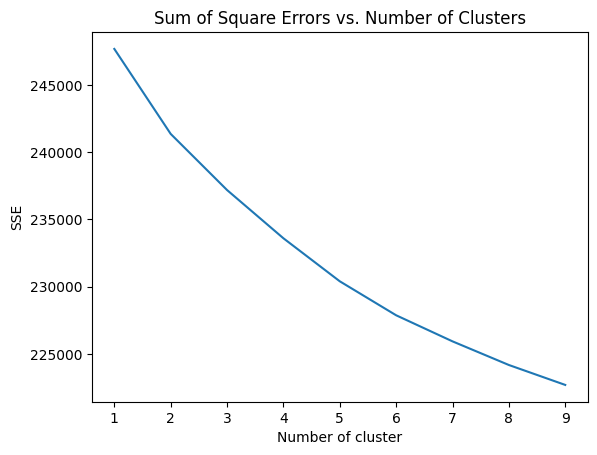

In [ ]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=200, random_state=True,  max_iter=1000).fit(X=word_vectors.vectors.astype('double'))
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Sum of Square Errors vs. Number of Clusters')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [34]:
model = KMeans(n_clusters=6, max_iter=1000, random_state=True, n_init=100)
labels = model.fit(X=word_vectors.vectors.astype('double'))

In [ ]:
print('Davies Bouldin Score: ', davies_bouldin_score(word_vectors.vectors.astype('double'), labels.labels_))
print('Calinski Harabasz Score: ', calinski_harabasz_score(word_vectors.vectors.astype('double'), labels.labels_))

Davies Bouldin Score:  3.94052741588994
Calinski Harabasz Score:  129.19804095330565


## Analysis of Clusters

In [ ]:
print(' ## Words found in cluster 0 ##')
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=50, restrict_vocab=None)

 ## Words found in cluster 0 ##


[('nationalistic', 0.7419905662536621),
 ('nationalism', 0.7199922800064087),
 ('encompass', 0.7065395712852478),
 ('regime', 0.6837404370307922),
 ('patriotic', 0.682215690612793),
 ('authoritarian', 0.6742655634880066),
 ('totalitarian', 0.6666761636734009),
 ('intolerance', 0.6617521643638611),
 ('theocratic', 0.6608919501304626),
 ('uphold', 0.6589691638946533),
 ('secularism', 0.6566293239593506),
 ('xenophobic', 0.6544418334960938),
 ('colonial', 0.652903139591217),
 ('marxist', 0.6501309275627136),
 ('ideological', 0.648766040802002),
 ('embrace', 0.6481760740280151),
 ('isolationist', 0.6434253454208374),
 ('christianity', 0.6405875086784363),
 ('align', 0.6317819356918335),
 ('reactionary', 0.6298163533210754),
 ('espouse', 0.623546838760376),
 ('isolationism', 0.6182826161384583),
 ('contradictory', 0.6180444955825806),
 ('statist', 0.617279589176178),
 ('oppose', 0.6118506789207458),
 ('laissez', 0.6112896800041199),
 ('patriotism', 0.6097524166107178),
 ('nationalist', 0.60

In [ ]:
print(' ## Words found in cluster 1 ##')
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=50, restrict_vocab=None)

 ## Words found in cluster 1 ##


[('communicate', 0.6528956890106201),
 ('immature', 0.6414459347724915),
 ('interact', 0.6256312727928162),
 ('selfish', 0.6238377094268799),
 ('inappropriate', 0.6223106384277344),
 ('behaviour', 0.6155641078948975),
 ('emotionally', 0.6113891005516052),
 ('hormonal', 0.6111546754837036),
 ('pester', 0.6094121932983398),
 ('judgment', 0.6081652641296387),
 ('obtuse', 0.6076530814170837),
 ('stmake', 0.6041022539138794),
 ('manipulative', 0.6001163721084595),
 ('apologize', 0.5996392965316772),
 ('sexually', 0.5986785292625427),
 ('disrespect', 0.5914411544799805),
 ('autonomy', 0.591350257396698),
 ('deviant', 0.5903379917144775),
 ('disrespectful', 0.5876566767692566),
 ('overreact', 0.587000846862793),
 ('bodily', 0.5848991274833679),
 ('abusive', 0.5821970701217651),
 ('stdefende', 0.5813587307929993),
 ('insecurity', 0.5802920460700989),
 ('disturbing', 0.5738630294799805),
 ('compulsive', 0.5723222494125366),
 ('indulge', 0.5702976584434509),
 ('harass', 0.5678443908691406),
 ('d

## Mapping Words to Sentences to Calculate Sentiment

In [35]:
reddit_filtered = reddit.copy().drop(['subreddit', 'bucket'], axis = 1)
reddit_filtered = reddit_filtered.drop_duplicates(subset='text')
tokenized = [row.split() for row in reddit_filtered['lemmatized'].astype(str)]
reddit_filtered['tokenized'] = tokenized
reddit_filtered = reddit_filtered.drop('lemmatized', axis = 1)
reddit_filtered['Word Vectors'] = reddit_filtered['tokenized'].apply(lambda x: [w2v_model.wv[word] for word in x if word in w2v_model.wv])

In [36]:
reddit_filtered

,text,annotation,class_label,tokenized,Word Vectors
0,"/r/france is pretty lively, with it's own ling...",Non-Moral,6,"[france, pretty, lively, lingo, usually, delib...","[[1.0365591, 0.50615567, -0.105633646, -0.1561..."
1,The Le Pen brand of conservatism and classical...,Non-Moral,6,"[le, pen, brand, conservatism, classical, righ...","[[0.01797173, 0.20345046, -0.62485147, -0.8056..."
2,"Clinton lead polls by 4%, well within a reason...",Non-Moral,6,"[clinton, lead, poll, reasonable, margin, lose...","[[-0.58419204, -0.9061363, 0.26216274, 0.09352..."
3,"Hey, fuck you. Us leftists will never support ...",Equality,2,"[hey, fuck, leftist, support, le, pen, especia...","[[-0.8086494, -0.5816069, -0.41931352, 0.57458..."
4,You are simplifying it. Islam is not the sole ...,Care,3,"[simplify, islam, not, sole, reason, terrorism...","[[0.20593089, 0.07061201, 0.3654067, -0.004660..."
...,...,...,...,...,...
8694,You’re very lucky no one snitched on you. I ha...,Loyalty,5,"[lucky, snitch, access, teacher, account, high...","[[0.095546566, 1.0233141, -0.71148723, -0.1643..."
8695,It did there is proof that it did if you go ba...,Authority,1,"[proof, look, look, mandela, effect, like, com...","[[0.92752695, -0.31168252, 0.12615876, 0.15528..."
8699,"At least you feel guilty, let’s you know you’r...",Care,3,"[feel, guilty, let, know, human, care, guess]","[[1.1380583, 0.62480915, -0.5451485, -1.015901..."
8700,Why are you dating this guy? Dude seems like a...,Care,3,"[date, guy, dude, like, giant, asshole, not, r...","[[0.4737537, 0.54256606, 0.11246107, 0.6129597..."


In [37]:
predictions = [model.predict(vec) for vec in reddit_filtered['Word Vectors'].values]
reddit_filtered['cluster_preds'] = predictions

In [38]:
reddit_filtered.head()

,text,annotation,class_label,tokenized,Word Vectors,cluster_preds
0,"/r/france is pretty lively, with it's own ling...",Non-Moral,6,"[france, pretty, lively, lingo, usually, delib...","[[1.0365591, 0.50615567, -0.105633646, -0.1561...","[2, 2, 1, 1, 1, 5, 1, 3, 4, 1, 3, 1, 0, 3, 5, ..."
1,The Le Pen brand of conservatism and classical...,Non-Moral,6,"[le, pen, brand, conservatism, classical, righ...","[[0.01797173, 0.20345046, -0.62485147, -0.8056...","[2, 2, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 1, 1, 4, ..."
2,"Clinton lead polls by 4%, well within a reason...",Non-Moral,6,"[clinton, lead, poll, reasonable, margin, lose...","[[-0.58419204, -0.9061363, 0.26216274, 0.09352...","[2, 2, 2, 5, 2, 2, 2, 2, 1, 2, 2, 2, 5, 5, 2]"
3,"Hey, fuck you. Us leftists will never support ...",Equality,2,"[hey, fuck, leftist, support, le, pen, especia...","[[-0.8086494, -0.5816069, -0.41931352, 0.57458...","[3, 3, 4, 4, 2, 2, 1, 5, 3, 3, 1, 1]"
4,You are simplifying it. Islam is not the sole ...,Care,3,"[simplify, islam, not, sole, reason, terrorism...","[[0.20593089, 0.07061201, 0.3654067, -0.004660...","[1, 4, 5, 5, 4, 4, 4, 1, 0, 0, 0, 0, 3, 0, 3, ..."


In [39]:
cluster_modes = []
for row in reddit_filtered.itertuples():
    val = list(row.cluster_preds)
    mode = max(set(val), key=val.count)
    cluster_modes.append(mode)
reddit_filtered['mode'] = cluster_modes

In [40]:
reddit_filtered['mean'] = reddit_filtered['cluster_preds'].apply(lambda x: round(np.mean(x)))

In [ ]:
reddit_filtered

,text,annotation,class_label,tokenized,Word Vectors,cluster_preds,mode,mean
0,"/r/france is pretty lively, with it's own ling...",Non-Moral,6,"[france, pretty, lively, lingo, usually, delib...","[[-0.776428, 0.96509284, 0.8285458, -0.7893579...","[3, 3, 5, 5, 5, 1, 5, 5, 0, 5, 2, 5, 4, 3, 1, ...",5,3
1,The Le Pen brand of conservatism and classical...,Non-Moral,6,"[le, pen, brand, conservatism, classical, righ...","[[0.09133122, 0.72307104, -0.6031244, 0.798511...","[3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, ...",0,1
2,"Clinton lead polls by 4%, well within a reason...",Non-Moral,6,"[clinton, lead, poll, reasonable, margin, lose...","[[-0.41072068, 0.6748384, -0.4285988, 0.009861...","[3, 3, 3, 1, 3, 3, 3, 3, 5, 3, 3, 3, 1, 1, 3]",3,3
3,"Hey, fuck you. Us leftists will never support ...",Equality,2,"[hey, fuck, leftist, support, le, pen, especia...","[[-0.79358184, -0.10363121, -0.6384472, 0.1863...","[2, 1, 0, 0, 3, 3, 5, 1, 2, 2, 5, 5]",2,2
4,You are simplifying it. Islam is not the sole ...,Care,3,"[simplify, islam, not, sole, reason, terrorism...","[[-0.15776512, -0.027759843, -0.09819014, -0.0...","[5, 0, 1, 1, 0, 0, 0, 5, 4, 0, 4, 5, 2, 4, 5, ...",1,2
...,...,...,...,...,...,...,...,...
8694,You’re very lucky no one snitched on you. I ha...,Loyalty,5,"[lucky, snitch, access, teacher, account, high...","[[-0.4658922, 0.119497344, 0.8065597, 0.238874...","[2, 5, 4, 2, 4, 3, 2, 1, 1, 2, 1]",2,2
8695,It did there is proof that it did if you go ba...,Authority,1,"[proof, look, look, mandela, effect, like, com...","[[-0.66497964, 0.14270383, 0.19828203, 0.56176...","[5, 2, 2, 5, 1, 1, 1, 5, 2, 1, 5, 2]",1,3
8699,"At least you feel guilty, let’s you know you’r...",Care,3,"[feel, guilty, let, know, human, care, guess]","[[0.5125173, 1.001773, 0.13409415, -0.91243184...","[1, 1, 1, 1, 1, 1, 5]",1,2
8700,Why are you dating this guy? Dude seems like a...,Care,3,"[date, guy, dude, like, giant, asshole, not, r...","[[-0.52952266, 0.39173764, 0.62160295, -0.4036...","[2, 2, 2, 1, 5, 1, 1, 1, 1, 1, 1, 0, 4, 5, 1, ...",1,2


## Cluster Analysis

In [ ]:
cluster0 = reddit_filtered.loc[reddit_filtered['mode']==0]
cluster0['annotation'].value_counts()

Equality           294
Authority          269
Non-Moral          153
Proportionality    121
Loyalty             91
Care                69
Name: annotation, dtype: int64

In [ ]:
for index,text in enumerate(cluster0['text'][:5]):
  print('Comment %d:\n'%(index+1),text)

Comment 1:
 The Le Pen brand of conservatism and classical right wing conservatism are almost entirely different. 

Right wing traditionally champions faith and family values, economic freedom and small(ish) government, which are the values that Fillon seems to promote. Le Pen is more authoritarian and statist in general, while also being pro abortion and gay marriage, the complete opposite on many issues.

As much as people might twitch at the mention of the term, Le Pen is ideologically closest to national socialism - pretty close in root philosophy, and as close as any modern politician gets in policy matters.
Comment 2:
 Nationalist parties all over Europe have always been opposed to LGBT rights. That's not "because Russia".

The Front National exists for more years than Putin has been doing propaganda in the West. And the opposition against gay marriage has always been part of their platform. In fact, when F. Hollande passed gay marriage a few years ago, there were massive protest

In [ ]:
cluster1 = reddit_filtered.loc[reddit_filtered['mode']==1]
cluster1['annotation'].value_counts()

Care               912
Equality           553
Non-Moral          539
Authority          525
Proportionality    478
Loyalty            223
Name: annotation, dtype: int64

In [ ]:
for index,text in enumerate(cluster1['text'][:5]):
  print('Comment %d:\n'%(index+1),text)

Comment 1:
 You are simplifying it. Islam is not the sole reason behind terrorism, western countries meddling in middle east, creating chaos, stealing resources and killing innocent people doesn't help. Funny that all these Trump and Le Pen supporters wouldn't care when their countries drops bombs and drone attack on innocent people.
Comment 2:
 Wow did not know all that! Maybe got some sources I can read?

Though even that considered honestly I'd prefer him over Fillon, Le Pen and Méchelon, since I'm very pro-europe
Comment 3:
 I haven't been following the french election and I'm sure there are many reasons to vote for each candidate, but I just wanted to say that I really respect Le Pens decision to refuse to wear a burqa. A lot of politicians are giving in to this and I don't like it. I'm not saying you should or shouldn't vote for her.


Comment 4:
 The point is that Hollande can screw them if he wants to.

He can stop giving them interviews, he probably has some sort of option to 

In [ ]:
cluster2 = reddit_filtered.loc[reddit_filtered['mode']==2]
cluster2['annotation'].value_counts()

Non-Moral          264
Care                92
Proportionality     79
Authority           69
Loyalty             45
Equality            41
Name: annotation, dtype: int64

In [ ]:
for index,text in enumerate(cluster2['text'][:5]):
  print('Comment %d:\n'%(index+1),text)

Comment 1:
 Hey, fuck you. Us leftists will never support Le Pen, especially considering her weird-ass Jew phobia.
Comment 2:
 A friend of mine is french and I keep sending her anything Macron related from /r/neoliberal and I'm not sure if she thinks it's funny or if she hates me. 
Comment 3:
 Can the US borrow your Macron for a little while please? I think our dear leader is defective.
Comment 4:
 Macron has a lot of weight on his shoulders. If he messes up, it's a big blow for progressives worldwide.
Comment 5:
 Same here dude, still fucking proud of our beautiful country. And I don't think Macron is that much of a shitter himself


In [ ]:
cluster3 = reddit_filtered.loc[reddit_filtered['mode']==3]
cluster3['annotation'].value_counts()

Non-Moral          290
Authority          248
Proportionality    158
Loyalty             94
Equality            66
Care                39
Name: annotation, dtype: int64

In [ ]:
for index,text in enumerate(cluster3['text'][:5]):
  print('Comment %d:\n'%(index+1),text)

Comment 1:
 Clinton lead polls by 4%, well within a reasonable margin for her to lose.  Le Pen trails in second round polls by 30-40%.  Not such a reasonable margin.
Comment 2:
 &gt; Valls is such a disgusting traitor to his own party

He helped Macron to win, thought.
Comment 3:
 Melenchon's party said they'll hold an internal referendum to decide if they'll "strongly endorse" Macron or having no official position (but still wouldn't support Le Pen)
Comment 4:
 But it's not because of her euroscepticism that they don't vote for Le Pen. It's more likely because they hate her love for the police and her religious undertone.
Comment 5:
 Hillary - Trump were 2-3 points off from each other.

Macron - Le Pen are 26 points apart.


In [ ]:
cluster4 = reddit_filtered.loc[reddit_filtered['mode']==4]
cluster4['annotation'].value_counts()

Proportionality    115
Authority           90
Equality            73
Non-Moral           65
Care                38
Loyalty             26
Name: annotation, dtype: int64

In [ ]:
for index,text in enumerate(cluster4['text'][:5]):
  print('Comment %d:\n'%(index+1),text)

Comment 1:
 I am prettty sure if Fillon gets elected he won't impose a theocracy neither will gay people stop getting married.

People will elect him to reduce immigration, reduce public spending and abolish the wealth tax and the 35 hour work week
Comment 2:
 That's a separate issue. I don't mind if the EU gets rid of that... but what Macron is saying is that Ireland should raise it's corporation tax from 12.5% to something much closer to the rest of Europe. If we do that then there's no real benefit for companies to invest in Ireland. I don't care if the EU cracks down on tax avoidance/loopholes. But when they tell member states what their tax rates should be that's when they overstep their authority. 
Comment 3:
 "France does need some authoritarian measures to eliminate extremism and Salafism in the country but it won't get them under Macron."

Liberty and security are not mutually exclusive propositions. 
Comment 4:
 &gt; with people earning more potentially ending up with less mo

In [ ]:
cluster5 = reddit_filtered.loc[reddit_filtered['mode']==5]
cluster5['annotation'].value_counts()

Non-Moral          152
Authority          113
Proportionality     92
Care                70
Equality            67
Loyalty             27
Name: annotation, dtype: int64

In [ ]:
for index,text in enumerate(cluster5['text'][:5]):
  print('Comment %d:\n'%(index+1),text)

Comment 1:
 /r/france is pretty lively, with it's own lingo that is usually deliberately bad translations - shitpost is "cacapoteau" or "compost", crosspost is "croixpoteau", etc. There's a mix of memes, politics, international news, personal problems, etc.

The election time was pretty entertaining, with people from /r/the_doofus coming over avd shilling for Le Pen, usually very badly.
Comment 2:
 &gt; Has any evidence linking Russia to the Macron leaks surfaced so far?

https://arstechnica.com/security/2017/05/evidence-suggests-russia-behind-hack-of-french-presidential-candidate/
Comment 3:
 If these were real the guy would have sent copies of the whole stack of documents to several reputable journals instead of posting a few photos on fucking 4chan. Until independent parties corroborate this it's *literally* fake news that's designed to stay in the public eye just long enough to survive the election.

You should honestly feel bad for not being more skeptical of it, regardless of you

Lets get rid of the NonMoral Class and see what happens

In [ ]:
reddit_5 = reddit.copy().drop(['subreddit', 'bucket'], axis = 1)
reddit_5 = reddit_5.loc[reddit_5['annotation'] != 'Non-Moral']
reddit_5 = reddit_5.drop_duplicates(subset='text')
tokenized = [row.split() for row in reddit_5['lemmatized'].astype(str)]
reddit_5['tokenized'] = tokenized
reddit_5 = reddit_5.drop('lemmatized', axis = 1)
reddit_5['Word Vectors'] = reddit_5['tokenized'].apply(lambda x: [w2v_model.wv[word] for word in x if word in w2v_model.wv])

In [ ]:
predictions = [model.predict(vec) for vec in reddit_5['Word Vectors'].values]
reddit_5['cluster_preds'] = predictions

NameError: ignored

In [ ]:
cluster_modes = []
for row in reddit_5.itertuples():
    val = list(row.cluster_preds)
    mode = max(set(val), key=val.count)
    cluster_modes.append(mode)
reddit_5['mode'] = cluster_modes

In [ ]:
cluster0 = reddit_5.loc[reddit_5['mode']==0]
cluster0['annotation'].value_counts()

Equality           299
Authority          271
Proportionality    124
Loyalty             93
Care                70
Name: annotation, dtype: int64

In [ ]:
cluster1 = reddit_5.loc[reddit_5['mode']==1]
cluster1['annotation'].value_counts()

Care               928
Equality           562
Authority          531
Proportionality    492
Loyalty            227
Name: annotation, dtype: int64

In [ ]:
cluster2 = reddit_5.loc[reddit_5['mode']==2]
cluster2['annotation'].value_counts()

Care               96
Proportionality    80
Authority          71
Loyalty            46
Equality           41
Name: annotation, dtype: int64

In [ ]:
cluster3 = reddit_5.loc[reddit_5['mode']==3]
cluster3['annotation'].value_counts()

Authority          255
Proportionality    161
Loyalty             96
Equality            68
Care                40
Name: annotation, dtype: int64

In [ ]:
cluster4 = reddit_5.loc[reddit_5['mode']==4]
cluster4['annotation'].value_counts()

Proportionality    119
Authority           92
Equality            74
Care                38
Loyalty             26
Name: annotation, dtype: int64

In [ ]:
cluster5 = reddit_5.loc[reddit_5['mode']==5]
cluster5['annotation'].value_counts()

Authority          119
Proportionality     95
Care                71
Equality            68
Loyalty             27
Name: annotation, dtype: int64

## Dimensionality Reduction

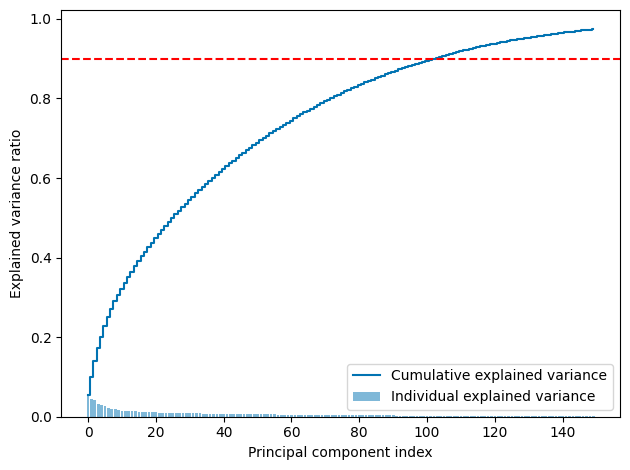

In [42]:
pca = PCA(n_components=150)
X_train = word_vectors.vectors.astype('double')
X_train = X_train - np.mean(X_train)
X_new_final = pca.fit_transform(X_train)

# pca =  PCA(n_components = 100)
# X_new = X_new_final - np.mean(X_new_final)
# X_new = pca.fit_transform(X_new)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=0.9, linestyle = '--', color='r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [43]:
pca = PCA(n_components=95)
X_train = word_vectors.vectors.astype('double')
X_train = X_train - np.mean(X_train)
X_new_final = pca.fit_transform(X_train)

In [44]:
model = KMeans(n_clusters=6, max_iter=1000, random_state=True, n_init=100)
labels = model.fit(X_new_final)

In [45]:
predictions_5 = [model.predict(pca.transform(vec- np.mean(vec))) for vec in reddit_5['Word Vectors'].values]
reddit_5['cluster_preds'] = predictions_5

In [46]:
distances_5 = [model.transform(pca.transform(vec- np.mean(vec))) for vec in reddit_5['Word Vectors'].values]

In [47]:
def normalize(l):
    #s = sum(l)
    # 
    min_val = []
    for i in l: 
      min_val.append(np.min(i))

    return [i/np.max(min_val) for i in min_val]

distances_norm = ([normalize(j) for j in distances_5])
distances_norm[0]

[0.4865391342893891,
 0.8774308874053748,
 0.5999196032147518,
 1.0,
 0.8607861858896472,
 0.8079219662637622,
 0.5472205407434863,
 0.6532473543101603,
 0.5312150726782876,
 0.5328562122252831,
 0.17420188276096563,
 0.14480409378451503]

In [48]:
reddit_5['distances'] = distances_norm

In [49]:
reddit_5

,text,annotation,tokenized,Word Vectors,cluster_preds,distances
3,"Hey, fuck you. Us leftists will never support ...",Equality,"[hey, fuck, leftist, support, le, pen, especia...","[[-0.79358184, -0.10363121, -0.6384472, 0.1863...","[3, 5, 3, 2, 0, 0, 3, 3, 3, 3, 3, 3]","[0.4865391342893891, 0.8774308874053748, 0.599..."
4,You are simplifying it. Islam is not the sole ...,Care,"[simplify, islam, not, sole, reason, terrorism...","[[-0.15776512, -0.027759843, -0.09819014, -0.0...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 2, ...","[0.15879376564270295, 0.680214078217071, 0.364..."
5,Wow did not know all that! Maybe got some sour...,Authority,"[wow, not, know, maybe, get, source, read, con...","[[0.06855803, 0.51584893, -0.005698696, -0.204...","[1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 4, 0, 0, 3, 4]","[0.37294847385360813, 0.3329624448346965, 0.53..."
7,&gt; Valls is such a disgusting traitor to his...,Loyalty,"[valls, disgusting, traitor, party, help, macr...","[[-0.107795775, -0.024073293, -0.4565645, 0.33...","[3, 3, 3, 0, 3, 0, 5, 1]","[0.2630486916348634, 0.37502499998379135, 0.31..."
8,Melenchon's party said they'll hold an interna...,Loyalty,"[melenchon, party, say, hold, internal, refere...","[[1.0996691, 1.8833346, -0.50229716, 0.848057,...","[0, 0, 5, 5, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, ...","[0.8192552026295326, 1.0, 0.5744219396072603, ..."
...,...,...,...,...,...,...
8694,You’re very lucky no one snitched on you. I ha...,Loyalty,"[lucky, snitch, access, teacher, account, high...","[[-0.4658922, 0.119497344, 0.8065597, 0.238874...","[3, 3, 2, 3, 3, 3, 5, 3, 4, 3, 3]","[0.3981757179924903, 0.14762582266270372, 0.49..."
8695,It did there is proof that it did if you go ba...,Authority,"[proof, look, look, mandela, effect, like, com...","[[-0.66497964, 0.14270383, 0.19828203, 0.56176...","[3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3]","[0.46703026522161734, 1.0, 0.9999999999999999,..."
8699,"At least you feel guilty, let’s you know you’r...",Care,"[feel, guilty, let, know, human, care, guess]","[[0.5125173, 1.001773, 0.13409415, -0.91243184...","[3, 3, 1, 3, 3, 3, 3]","[1.0, 0.501666382158336, 0.751894448522213, 0...."
8700,Why are you dating this guy? Dude seems like a...,Care,"[date, guy, dude, like, giant, asshole, not, r...","[[-0.52952266, 0.39173764, 0.62160295, -0.4036...","[3, 1, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, ...","[0.535281351842397, 0.6896380696671373, 0.4964..."


In [54]:
weighted_avg = []
for row in reddit_5.itertuples(): 
  weighted_avg.append(np.mean(row.distances * row.cluster_preds))

In [58]:
reddit_5['class_pred'] = np.round(weighted_avg)
reddit_5['class_pred'].value_counts()

2.0    2924
1.0    2251
3.0      88
0.0      13
4.0       4
Name: class_pred, dtype: int64

In [ ]:
cluster_modes = []
for row in reddit_5.itertuples():
    val = list(row.cluster_preds)
    mode = max(set(val), key=val.count)
    cluster_modes.append(mode)
reddit_5['mode'] = cluster_modes

In [ ]:
reddit_5['mode'].value_counts()

4    2369
0     834
1     781
5     446
2     434
3     416
Name: mode, dtype: int64

# Using LSA for Clustering

In [14]:
idx = reddit.loc[reddit['annotation']=='Non-Moral'].index
reddit = reddit.drop(idx, axis = 0)

In [15]:
reddit.head()

,text,subreddit,bucket,annotation,lemmatized,class_label
3,"Hey, fuck you. Us leftists will never support ...",worldnews,French politics,Equality,hey fuck leftist support le pen especially con...,2
4,You are simplifying it. Islam is not the sole ...,europe,French politics,Care,simplify islam not sole reason terrorism weste...,3
5,Wow did not know all that! Maybe got some sour...,europe,French politics,Authority,wow not know maybe get source read consider ho...,1
7,&gt; Valls is such a disgusting traitor to his...,europe,French politics,Loyalty,valls disgusting traitor party help macron win...,5
8,Melenchon's party said they'll hold an interna...,europe,French politics,Loyalty,melenchon party say hold internal referendum d...,5


In [61]:
tfidf = TfidfVectorizer(min_df = 5, max_df = 0.85, use_idf = True, lowercase = False)
X = tfidf.fit_transform(reddit['lemmatized'].values)
X.shape

(7010, 3089)

In [62]:
terms = tfidf.get_feature_names_out()
terms

array(['abandon', 'abhorrent', 'ability', ..., 'zero', 'zombie', 'zone'],
      dtype=object)

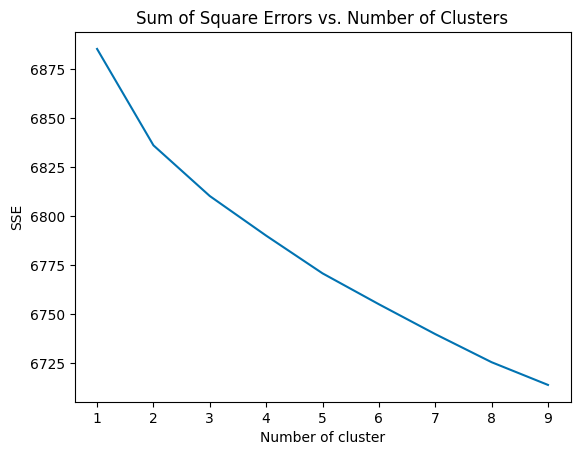

In [66]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42, max_iter=1000).fit(X.toarray())
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Sum of Square Errors vs. Number of Clusters')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

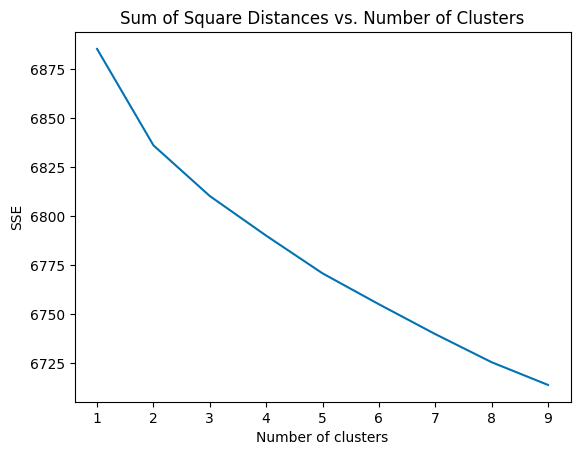

In [70]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Sum of Square Distances vs. Number of Clusters')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")

plt.savefig('sse_tfidf.png',pad_inches=0.1,
        facecolor='white')


plt.show()

In [71]:
knn = KMeans(n_clusters=5, max_iter=1000, random_state=42, n_init=100)
knn.fit(X)
knn_clusters = knn.labels_.tolist()

In [72]:
print('Davies Bouldin Score: ', davies_bouldin_score(X.toarray(), knn_clusters))
print('Calinski Harabasz Score: ', calinski_harabasz_score(X.toarray(), knn_clusters))

Davies Bouldin Score:  10.78090393443723
Calinski Harabasz Score:  29.623881105320713


In [86]:
U, sigma, VT = randomized_svd(X, n_components=4, n_iter = 100, random_state=42)

In [88]:
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:25]
        print("Concept "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

Concept 0: 
not
le
pen
people
macron
like
vote
want
think
right
trump
know
racist
france
thing
say
good
french
need
go
support
mean
win
way
eu
 
Concept 1: 
le
pen
vote
france
fascist
win
french
party
right
trump
nazi
eu
marine
anti
far
macron
support
round
fn
nationalist
election
putin
europe
nationalism
immigration
 
Concept 2: 
macron
france
vote
win
eu
fillon
right
french
good
merkel
know
leader
president
hollande
hamon
candidate
go
election
liberal
country
year
well
need
left
guy
 
Concept 3: 
people
racist
right
like
think
white
black
hate
way
thing
macron
vote
far
believe
make
call
trump
look
hard
life
group
good
leader
racism
etc
 


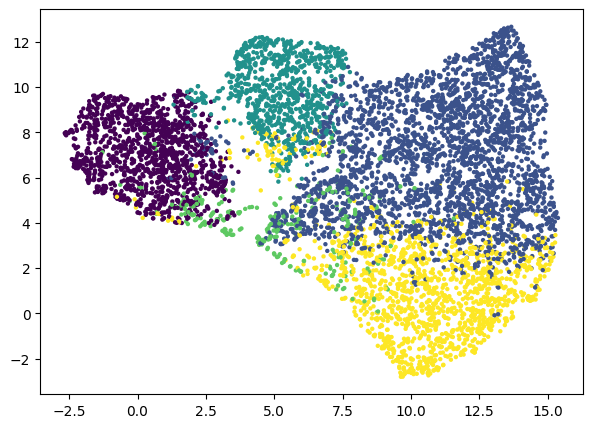

In [85]:
U, sigma, VT = randomized_svd(X, n_components=4, n_iter = 100, random_state=42)
X_topics= U*sigma
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = knn_clusters,
            s = 10, # size
            edgecolor='none')
plt.show()

# Twitter

In [ ]:
## Reading in Lemmatized data 
tweets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DNN project/lemmatized_tweets.csv')
tweets.drop('Unnamed: 0', axis = 1, inplace=True)

tweets.isna().sum()

In [ ]:
tweets[tweets['lemmatized'].isna()]

,Party,Handle,Tweet,cleaned,lemmatized
14605,Democrat,RepSwalwell,This!! https://t.co/aENZ1JWKPS,this,NaN
38783,Democrat,cbrangel,Already been in! https://t.co/0vygG9pvPY https...,already been in,NaN
39459,Democrat,RepSteveIsrael,"Well, there you go... \nhttps://t.co/Nrxx1zRny...",well there you go,NaN
40667,Democrat,NancyPelosi,It already is. https://t.co/2CqWTjnPED,it already is,NaN
40862,Democrat,chelliepingree,#Enough https://t.co/nm56WR3Ohu,enough,NaN
40863,Democrat,chelliepingree,#Enough https://t.co/P7iWJqi2jx,enough,NaN
40864,Democrat,chelliepingree,#Enough https://t.co/Htbf6VePXD,enough,NaN
44745,Republican,HouseSmallBiz,This 👇🏽 https://t.co/dJsl6N43GE,this,NaN
65305,Republican,RepLouBarletta,RT @SteveScalise: 👀 https://t.co/Zg25P4eH5j,NaN,NaN
69073,Republican,RepDavid,https://t.co/dP6gpqaIdu @WaysandMeansGOP https...,NaN,NaN


In [ ]:
tweets.dropna(inplace=True)
tweets.reset_index(inplace=True)
tweets.shape

(85107, 6)

In [ ]:
 # creates a list of strings for each row in restaurants 
sent = [row.split() for row in tweets['lemmatized'].astype(str)]
#print(sent[:3])

# looking for bigrams (based on kaggle notebook cited above)
phrases = Phrases(sent, min_count=30, progress_per=10000) 
bigram = Phraser(phrases)
sentences = bigram[sent]

NameError: ignored

In [ ]:
tweets['tokenized'] = sent

In [ ]:
tweets.head()

,index,Party,Handle,Tweet,cleaned,lemmatized,tokenized
0,0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote to savetheinternet prou...,today senate dem vote savetheinternet proud su...,"[today, senate, dem, vote, savetheinternet, pr..."
1,1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter haven resident alta vist...,winterhavensun winter haven resident alta vist...,"[winterhavensun, winter, haven, resident, alta..."
2,2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,nbclatino noted that hurricane maria has left ...,nbclatino note hurricane maria leave approxima...,"[nbclatino, note, hurricane, maria, leave, app..."
3,3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,nalcabpolicy meeting with thanks for taking th...,nalcabpolicy meeting thank take time meet lati...,"[nalcabpolicy, meeting, thank, take, time, mee..."
4,4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,vegalteno hurricane season starts on june st p...,vegalteno hurricane season start june st puert...,"[vegalteno, hurricane, season, start, june, st..."


## Word2Vec and KMeans

Word2Vec parameters are based on initialization in github code linked above. The initial parameters we checked are: 

* min count = 3 - remove most unusual words from training embeddings, like words 'ssssuuuuuuuppppppeeeeeerrrr', which actually stands for 'super', and doesn't need additional training
* window = 4 - Word2Vec model will learn to predict given word from up to 4 words to the left, and up to 4 words to the right
* vector_size = 300 - size of hidden layer used to predict surroundings of embedded word, which also stands for dimensions of trained embeddings
* sample = 1e-5 - probability baseline for subsampling most frequent words from surrounding of embedded word
* negative = 20 - number of negative (ones that shouldn't have been predicted while modeling selected pair of words) words that will have their corresponding weights updated while training on specific training example, along with positive word 

[citation: https://github.com/rafaljanwojcik/Unsupervised-Sentiment-Analysis/blob/master/preprocessing_and_embeddings/Preprocessing_and_Embeddings.ipynb] 



In [ ]:
## Initializing Word2Vec model 
w2v_model = Word2Vec(min_count=2,
                     window=5,
                     epochs = 10,
                     vector_size=300,
                    #  sample=1e-5, 
                    #  alpha=0.03, 
                    #  min_alpha=0.0007, 
                    #  negative=20,
                     workers=multiprocessing.cpu_count()-1)

#start = time()
w2v_model.build_vocab(sentences, progress_per=50000)
#print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

In [ ]:
## Training Word2Vec Model 
start = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

Time to train the model: 2.2 mins


In [ ]:
# saves model 
w2v_model.save("/content/drive/MyDrive/Colab Notebooks/DNN project/word2vec300.model")

KMeans Clustering 

In [ ]:
# loading trained Word2Vec model 
word_vectors = Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/DNN project/word2vec300.model").wv

In [ ]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=True,  max_iter=1000).fit(X=word_vectors.vectors.astype('double'))
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Sum of Square Errors vs. Number of Clusters')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


We initialize and train a K Means Clustering algorithm with 3 clusters, that runs for 1000 iterations and chooses 100 random starting points for initial cluster centers. 

In [ ]:
model = KMeans(n_clusters=4, max_iter=1000, random_state=True, n_init=100)
labels = model.fit(X=word_vectors.vectors.astype('double'))

In [ ]:
davies_bouldin_score(word_vectors.vectors.astype('double'), labels.labels_)

3.958883032802854

In [ ]:
print(' ## Words found in cluster 0 ##')
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=50, restrict_vocab=None)

 ## Words found in cluster 0 ##


[('andrewm', 0.9602551460266113),
 ('pinnaclesnps', 0.955412745475769),
 ('honorimmigrantmom', 0.9515284895896912),
 ('kybroadcaster', 0.9493262767791748),
 ('spomy', 0.9472069144248962),
 ('senatorhughe', 0.9393095374107361),
 ('freddiegray', 0.9364321827888489),
 ('assassinat', 0.9345161318778992),
 ('maejemison', 0.9345155358314514),
 ('notcrumb', 0.9344877004623413),
 ('walterscott', 0.9293340444564819),
 ('janine', 0.9284632205963135),
 ('submissio', 0.9249209761619568),
 ('hein', 0.9237857460975647),
 ('uiowa', 0.9237602353096008),
 ('cattleman', 0.9222773909568787),
 ('tamirrice', 0.9219794869422913),
 ('roxanne', 0.9198166728019714),
 ('schwarzenegger', 0.9183457493782043),
 ('mobileme', 0.9169073700904846),
 ('marriageequality', 0.9156725406646729),
 ('edna', 0.9130969643592834),
 ('findyourpar', 0.9123943448066711),
 ('lindasoltis', 0.9114506244659424),
 ('endtrafficking', 0.9110512137413025),
 ('michael_sh', 0.9106375575065613),
 ('pascogovaffair', 0.9094647169113159),
 ('hi

In [ ]:
print(' ## Words found in cluster 1 ##')
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=100, restrict_vocab=None)

 ## Words found in cluster 1 ##


[('weiland', 0.819212019443512),
 ('hadiya', 0.7997539043426514),
 ('alicia', 0.7976526618003845),
 ('zachary', 0.7930262684822083),
 ('patton', 0.7916866540908813),
 ('lois', 0.7914383411407471),
 ('ivan', 0.7880432605743408),
 ('allison', 0.7846457362174988),
 ('golick', 0.7838576436042786),
 ('coeur', 0.7766432762145996),
 ('loeber', 0.7750039100646973),
 ('dylan', 0.7728030681610107),
 ('marvin', 0.7680347561836243),
 ('jesse', 0.7664873600006104),
 ('madeleine', 0.7632026672363281),
 ('legendary', 0.763171374797821),
 ('christy', 0.7605030536651611),
 ('casey', 0.7594823837280273),
 ('dale', 0.7587406635284424),
 ('jensen', 0.7579381465911865),
 ('assemblyman', 0.7567278146743774),
 ('cowboy', 0.7564092874526978),
 ('plowboy', 0.756384015083313),
 ('saluda', 0.7554965019226074),
 ('amy', 0.7551969289779663),
 ('phillip', 0.7546641826629639),
 ('meyer', 0.7543261051177979),
 ('gonzales', 0.7527309060096741),
 ('holt', 0.7526661157608032),
 ('beta', 0.7502456903457642),
 ('alec', 0.

In [ ]:
print(' ## Words found in cluster 2 ##')
word_vectors.similar_by_vector(model.cluster_centers_[2], topn=50, restrict_vocab=None)

 ## Words found in cluster 2 ##


[('reduction', 0.7149662971496582),
 ('incentive', 0.619285523891449),
 ('marketplace', 0.60341876745224),
 ('charitable', 0.5921064019203186),
 ('tax_credit', 0.5814910531044006),
 ('strain', 0.5795682072639465),
 ('net', 0.5768100023269653),
 ('fuel', 0.5755610466003418),
 ('shrink', 0.5751141309738159),
 ('emission', 0.5730259418487549),
 ('bil', 0.5722424983978271),
 ('efficiency', 0.5709924697875977),
 ('incentivize', 0.5701623558998108),
 ('stabilize', 0.5662107467651367),
 ('affordable', 0.5659348368644714),
 ('sharing', 0.5623279809951782),
 ('expensing', 0.56123286485672),
 ('affordable_housing', 0.557955265045166),
 ('dramatically', 0.557060956954956),
 ('foodandfarmact', 0.5565859079360962),
 ('medica', 0.5563791990280151),
 ('insurance', 0.5563374757766724),
 ('efficient', 0.5549075603485107),
 ('deduction', 0.5520517826080322),
 ('income', 0.5488236546516418),
 ('red_tape', 0.5485240817070007),
 ('economically', 0.5461283922195435),
 ('economic_growth', 0.5449520349502563)

## Sentiment Analysis 

In [ ]:
## Computes a weighted sentiment score for each word using the distance from the word to the cluster centers and which cluster the word belongs to 
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words.head(10)

,words,vectors,cluster,closeness_score
0,amp,"[0.2898353, -0.20299608, 0.5114571, -0.0340515...",2,0.088379
1,today,"[-1.9883674, 0.69460434, -0.6445517, -0.866201...",0,0.078495
2,thank,"[0.63698596, -0.12549466, -0.26471207, -0.3075...",1,0.070973
3,work,"[-0.46737465, -0.81546587, -1.0341592, 0.91236...",2,0.065897
4,great,"[-0.3047436, -0.844154, 0.16995072, -0.6042836...",1,0.069274
5,join,"[0.6893757, 1.730053, 1.2007695, 1.158957, -1....",1,0.056079
6,day,"[0.36446264, -2.518898, -0.7543709, 0.64361256...",1,0.060728
7,family,"[0.9634131, 1.8483765, 1.4326607, 0.85107946, ...",2,0.057117
8,year,"[-0.49334794, 0.3193868, 0.40565896, -0.939703...",2,0.058241
9,bill,"[0.45050013, 1.5937599, -1.4559039, 0.09617642...",2,0.058421


In [ ]:
words.loc[words['cluster']==0].sort_values(by ='closeness_score', ascending=True)[:20]

,words,vectors,cluster,closeness_score
19,discuss,"[-1.1188035, 4.313947, -0.18141302, -1.4226267...",0,0.042178
28,talk,"[-0.3081307, 2.112598, 0.4757855, -1.8950574, ...",0,0.046879
35,speak,"[0.2603114, 1.5839957, -1.1231306, 0.22482134,...",0,0.046902
45,member,"[-1.5453093, 0.39367938, 1.0611856, -0.3713813...",0,0.047395
44,live,"[-0.8867171, -0.53635263, -1.5704755, 0.414886...",0,0.049066
37,hear,"[1.4050907, 1.8836691, -1.348982, -2.0276062, ...",0,0.050389
20,w,"[0.23149537, 0.1495782, 0.72920156, 1.9009824,...",0,0.050511
117,congressional,"[0.012774998, 0.17460687, 0.5217133, 1.3936143...",0,0.050792
69,stop,"[0.39162508, -0.79273194, 0.24622671, -0.73518...",0,0.051587
92,leader,"[-0.66824037, 1.6098723, 0.7172321, 1.4862769,...",0,0.052398


In [ ]:
words.loc[words['cluster']==1].sort_values(by ='closeness_score', ascending=True)[:20]

,words,vectors,cluster,closeness_score
81,county,"[0.87066704, -0.4201343, 1.1512285, 1.3435771,...",1,0.043801
25,meet,"[-0.6673244, 1.428857, 0.47579363, -0.43467483...",1,0.045523
32,visit,"[-0.60008484, 2.6169868, 0.034629572, 0.855858...",1,0.046253
147,award,"[-1.6957524, -0.7509603, -0.2854541, -1.713877...",1,0.046777
76,congratulation,"[1.1758585, -0.679819, -1.2599295, 0.5282814, ...",1,0.047007
15,student,"[2.9518778, 2.1688638, -1.7508478, -2.2707114,...",1,0.047173
220,town_hall,"[-0.022293173, 1.7253215, -0.2548037, 1.232522...",1,0.047829
90,host,"[0.65268874, 0.7184561, -0.26965535, 0.4482357...",1,0.048007
67,office,"[-0.14366214, -1.6686043, 2.6976597, 1.1123352...",1,0.048369
24,morning,"[-1.6704437, 1.3656435, -0.30488604, 0.5152638...",1,0.049559


In [ ]:
words.loc[words['cluster']==2].sort_values(by ='closeness_score', ascending=True)[:20]

,words,vectors,cluster,closeness_score
36,woman,"[-0.08205685, -0.94247866, 1.3903869, -0.13690...",2,0.043304
68,national,"[-1.0710576, -0.39884752, 0.50118655, 0.624239...",2,0.043974
58,veteran,"[-2.2625341, 1.2194031, 0.60155594, 0.7476321,...",2,0.045798
49,job,"[-0.17631228, 1.2551386, -0.29763, 0.6058556, ...",2,0.046086
74,life,"[-1.6728135, -0.868778, 3.1020637, -0.27763087...",2,0.046529
126,tax_cut,"[-0.267054, 0.10087475, -0.7213889, 0.4204178,...",2,0.047174
29,state,"[-0.34939045, 0.5084442, -1.40566, 0.19465344,...",2,0.047183
13,act,"[-1.3290318, 1.9325126, -1.9596117, -0.6263031...",2,0.047212
21,community,"[-0.8799766, 0.36660185, 0.18624823, -2.859552...",2,0.047371
51,american,"[1.0589901, 2.837946, -0.6580309, -0.082768284...",2,0.048327


In [ ]:
cluster_counts = []
for tweet in tweets['tokenized'].values: 
  counts = [words.loc[words['words'] == token, 'cluster'].values[0] for token in tweet if token in words['words'].values]
  cluster_counts.append(counts)

In [ ]:
tweets['cluster_counts'] = cluster_counts

In [ ]:
naned = []

for row in tweets.itertuples():
  if len(row.cluster_counts) < 1: 
    naned.append(1)
  else: 
    naned.append(0)

tweets['counts_isna'] = naned

In [ ]:
tweets.loc[tweets['counts_isna'] == 1]

,index,Party,Handle,Tweet,cleaned,lemmatized,tokenized,cluster_counts,counts_isna
370,370,Democrat,RepAlLawsonJr,@gmitter @ActionNewsJax \n@wjxt4 @FCN2go\nhttp...,gmitter actionnewsjax wjxt fcn go,gmitter actionnewsjax wjxt fcn,"[gmitter, actionnewsjax, wjxt, fcn]",[],1
1178,1178,Democrat,RepTomSuozzi,@HuntTownHall,hunttownhall,hunttownhall,[hunttownhall],[],1
2475,2475,Democrat,RepLouCorrea,@HouseHomeland @Tyrnn,tyrnn,tyrnn,[tyrnn],[],1
3065,3065,Democrat,CongressmanRaja,Ramble on! https://t.co/SCDRSDzyBA,ramble on,ramble,[ramble],[],1
3067,3067,Democrat,CongressmanRaja,@alexburnsNYT (Chastened nodding),alexburnsnyt chastened nodding,alexburnsnyt chasten nod,"[alexburnsnyt, chasten, nod]",[],1
...,...,...,...,...,...,...,...,...,...
79520,79530,Republican,RepKevinBrady,It’s what roomies are here for! https://t.co/S...,its what roomies are here for,roomie,[roomie],[],1
81871,81881,Republican,JudgeCarter,#GoArmy! https://t.co/m5Z0GysMex,goarmy,goarmy,[goarmy],[],1
81952,81962,Republican,JudgeCarter,#FirstTeam https://t.co/pxD5RN4Gq3,firstteam,firstteam,[firstteam],[],1
83460,83470,Republican,LamarSmithTX21,RT @TxStHistAssoc: https://t.co/tViWMkx3mW,txsthistassoc,txsthistassoc,[txsthistassoc],[],1


In [ ]:
cluster_modes = []
for row in tweets.itertuples():
  if row.counts_isna == 0: 
    val = row.cluster_counts
    mode = max(set(val), key=val.count)
    cluster_modes.append(mode)
  else: 
    cluster_modes.append(np.nan)

NameError: ignored

In [ ]:
tweets['mode'] = cluster_modes

In [ ]:
tweets

,index,Party,Handle,Tweet,cleaned,lemmatized,tokenized,cluster_counts,counts_isna,mode
0,0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote to savetheinternet prou...,today senate dem vote savetheinternet proud su...,"[today, senate, dem, vote, savetheinternet, pr...","[1, 2, 2, 2, 2, 1, 2, 3, 2, 2]",0,2.0
1,1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter haven resident alta vist...,winterhavensun winter haven resident alta vist...,"[winterhavensun, winter, haven, resident, alta...","[0, 1, 1, 1, 0, 1, 4, 4, 1, 4, 0]",0,1.0
2,2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,nbclatino noted that hurricane maria has left ...,nbclatino note hurricane maria leave approxima...,"[nbclatino, note, hurricane, maria, leave, app...","[0, 2, 0, 1, 0, 0, 3, 0, 2, 2]",0,0.0
3,3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,nalcabpolicy meeting with thanks for taking th...,nalcabpolicy meeting thank take time meet lati...,"[nalcabpolicy, meeting, thank, take, time, mee...","[1, 1, 2, 0, 1, 0]",0,1.0
4,4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,vegalteno hurricane season starts on june st p...,vegalteno hurricane season start june st puert...,"[vegalteno, hurricane, season, start, june, st...","[0, 1, 0, 1, 1, 1, 0, 2, 0]",0,0.0
...,...,...,...,...,...,...,...,...,...,...
85102,85112,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...,check out my op ed on need for end executive o...,check op ed need end executive overreach act w...,"[check, op, ed, need, end, executive, overreac...","[0, 0, 0, 3, 2, 2, 2, 3, 4, 2, 0, 3, 2]",0,2.0
85103,85113,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear...",yesterday betty amp i had a great time learnin...,yesterday betty amp great time learn forestry ...,"[yesterday, betty, amp, great, time, learn, fo...","[1, 1, 0, 1, 0, 1, 0, 0, 3, 0, 0, 1]",0,0.0
85104,85114,Republican,RepTomPrice,We are forever grateful for the service and sa...,we are forever grateful for the service and sa...,forever grateful service sacrifice major barney,"[forever, grateful, service, sacrifice, major,...","[4, 4, 4, 4, 0]",0,4.0
85105,85115,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...,happy first day of school cobbschools cobbback...,happy day school cobbschool cobbbacktoschool,"[happy, day, school, cobbschool, cobbbacktosch...","[4, 4, 1]",0,4.0


In [ ]:
democrats = tweets.loc[tweets['Party']=='Democrat']
republican = tweets.loc[tweets['Party']=='Republican']

In [ ]:
democrats['mode'].value_counts()

0.0    13799
2.0    10334
1.0     9951
3.0     4856
4.0     2285
Name: mode, dtype: int64

In [ ]:
republican['mode'].value_counts()

0.0    13118
1.0    11919
2.0    10166
3.0     5922
4.0     2689
Name: mode, dtype: int64